In [1]:
!pip install albumentations

In [23]:
import os
import pandas as pd
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from albumentations.core.bbox_utils import BboxParams
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, optimizers

In [3]:
!git clone https://github.com/GunaGumilar/rice_diseaseV2

Cloning into 'rice_diseaseV2'...
remote: Enumerating objects: 1180, done.
remote: Counting objects: 100% (1180/1180), done.
remote: Compressing objects: 100% (1170/1170), done.
remote: Total 1180 (delta 26), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (1180/1180), 21.37 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [24]:
def validate_images(csv_path, img_dir):
    """
    Validasi apakah semua file gambar di CSV ada di folder gambar.

    Parameters:
        csv_path (str): Path ke file CSV.
        img_dir (str): Path ke folder gambar.

    Returns:
        DataFrame: DataFrame hanya dengan file yang memiliki gambar valid.
    """
    df = pd.read_csv(csv_path)
    df['image_exists'] = df['filename'].apply(lambda x: os.path.isfile(os.path.join(img_dir, x)))
    valid_df = df[df['image_exists']]
    valid_df = valid_df.drop(columns=['image_exists'])

    missing_images = df[~df['image_exists']]
    print(f"Total images: {len(df)}")
    print(f"Valid images: {len(valid_df)}")
    print(f"Missing images: {len(missing_images)}")

    if not missing_images.empty:
        print("Missing images:")
        print(missing_images['filename'].values)

    return valid_df

In [25]:
train_df = validate_images('/content/rice_diseaseV2/Rice_Leafe_Disease/bbox_train/_annotations.csv', '/content/rice_diseaseV2/Rice_Leafe_Disease/train/')
valid_df = validate_images('/content/rice_diseaseV2/Rice_Leafe_Disease/bbox_valid/_annotations.csv', '/content/rice_diseaseV2/Rice_Leafe_Disease/valid/')
test_df = validate_images('/content/rice_diseaseV2/Rice_Leafe_Disease/bbox_test/_annotations.csv', '/content/rice_diseaseV2/Rice_Leafe_Disease/test/')

Total images: 1178
Valid images: 1178
Missing images: 0
Total images: 28
Valid images: 28
Missing images: 0
Total images: 20
Valid images: 20
Missing images: 0


In [26]:
train_df.to_csv('/content/rice_diseaseV2/validated/train/validated_train.csv', index=False)
valid_df.to_csv('/content/rice_diseaseV2/validated/valid/validated_valid.csv', index=False)
test_df.to_csv('/content/rice_diseaseV2/validated/test/validated_test.csv', index=False)


In [27]:
class YoloDataGenerator(Sequence):
    def __init__(self, csv_path, img_dir, input_size=(416, 416), batch_size=8, augment=False):
        self.annotations = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.input_size = input_size
        self.batch_size = batch_size
        self.augment = augment

        # Pastikan bounding box dalam format float
        self.annotations[['xmin', 'ymin', 'xmax', 'ymax']] = self.annotations[['xmin', 'ymin', 'xmax', 'ymax']].astype('float32')

        # Encode class labels jika berupa string
        self.class_map = {label: idx for idx, label in enumerate(self.annotations['class'].unique())}
        self.annotations['class'] = self.annotations['class'].map(self.class_map)

        self.transform = A.Compose(
            [
                A.Resize(*input_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2)
            ],
            bbox_params=BboxParams(format='pascal_voc', label_fields=['class_labels'])
        ) if augment else A.Compose(
            [A.Resize(*input_size)],
            bbox_params=BboxParams(format='pascal_voc', label_fields=['class_labels'])
        )

    def __len__(self):
        return len(self.annotations) // self.batch_size

    def __getitem__(self, idx):
        batch_data = self.annotations.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        bboxes = []
        class_labels = []

        for _, row in batch_data.iterrows():
            img_path = os.path.join(self.img_dir, row['filename'])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            bbox = row[['xmin', 'ymin', 'xmax', 'ymax']].values
            label = row['class']

            transformed = self.transform(
                image=image,
                bboxes=[bbox],
                class_labels=[label]
            )

            images.append(transformed['image'] / 255.0)
            bboxes.append(transformed['bboxes'][0])
            class_labels.append(label)

        return np.array(images, dtype='float32'), {
            "bboxes": np.array(bboxes, dtype='float32'),
            "class_labels": np.array(class_labels, dtype='int32')
        }

    def get_label_map(self):
        return {v: k for k, v in self.class_map.items()}

In [28]:
train_generator = YoloDataGenerator(
    csv_path='/content/rice_diseaseV2/validated/train/validated_train.csv',
    img_dir='/content/rice_diseaseV2/Rice_Leafe_Disease/train/',
    batch_size=8,
    augment=True
)

In [29]:
valid_generator = YoloDataGenerator(
    csv_path='/content/rice_diseaseV2/validated/valid/validated_valid.csv',
    img_dir='/content/rice_diseaseV2/Rice_Leafe_Disease/valid/',
    batch_size=8,
    augment=False
)

In [30]:
test_generator = YoloDataGenerator(
    csv_path='/content/rice_diseaseV2/validated/test/validated_test.csv',
    img_dir='/content/rice_diseaseV2/Rice_Leafe_Disease/test/',
    batch_size=8,
    augment=False
)

In [31]:
label_map = train_generator.get_label_map()
print("Label Map:", label_map)

Label Map: {0: 'Bercak Coklat -Helminthosporium oryzae-', 1: 'Hawar Daun Bakteri -Xanthomonas oryzae-', 2: 'Bercak Daun -Ustilaginoidea virens-', 3: nan, 4: 'Health'}


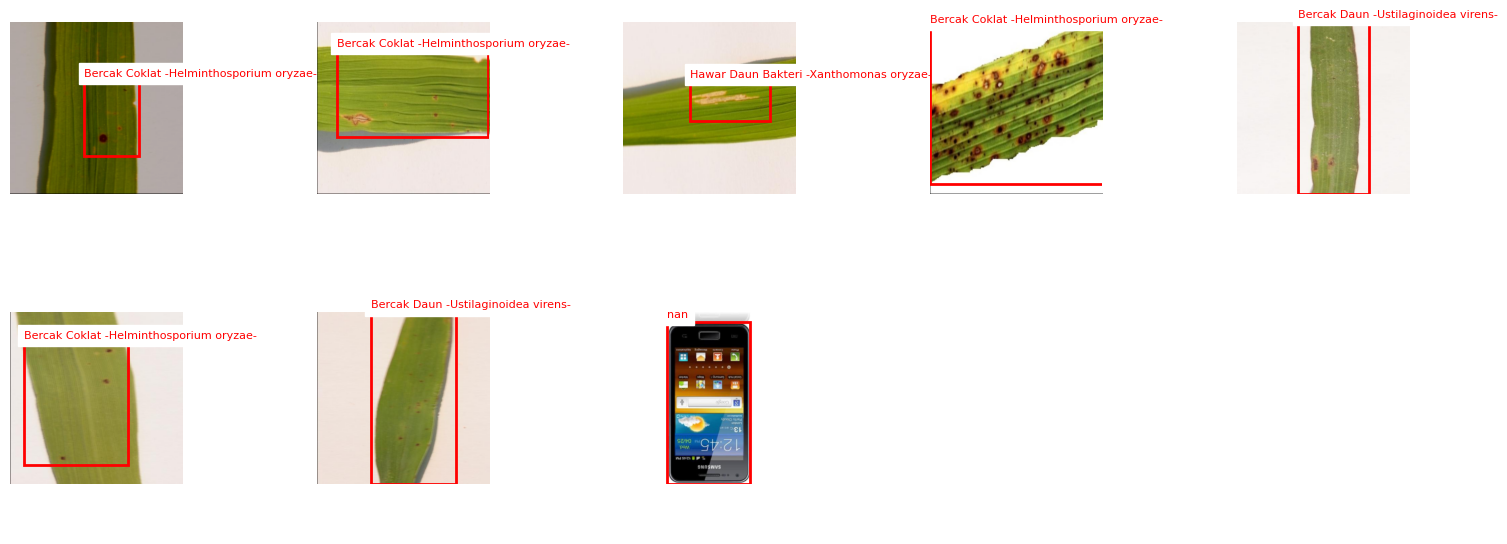

In [32]:
def display_batch_with_bboxes(images, targets, label_map, max_cols=5):
    """
    Menampilkan batch gambar dengan bounding box secara horizontal.

    Parameters:
        images (numpy array): Batch gambar (array numpy).
        targets (dict): Dictionary berisi "bboxes" dan "class_labels".
        label_map (dict): Peta label (id ke nama kelas).
        max_cols (int): Jumlah maksimum kolom (gambar) dalam satu baris.
    """
    num_images = len(images)
    num_rows = (num_images + max_cols - 1) // max_cols  # Hitung jumlah baris

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(15, 3 * num_rows))
    axes = axes.ravel()  # Flatten axes untuk looping mudah

    for i in range(len(axes)):
        if i < num_images:
            ax = axes[i]
            img = (images[i] * 255).astype('uint8')  # Ubah ke format 0-255
            bboxes = targets["bboxes"][i]
            class_labels = targets["class_labels"][i]

            # Tampilkan gambar
            ax.imshow(img)
            ax.axis('off')

            # Gambar bounding box
            for bbox, label in zip([bboxes], [class_labels]):
                xmin, ymin, xmax, ymax = bbox
                width = xmax - xmin
                height = ymax - ymin
                rect = patches.Rectangle(
                    (xmin, ymin), width, height,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                label_name = label_map[label]
                ax.text(
                    xmin, ymin - 10, label_name,
                    color='red', fontsize=8, backgroundcolor='white'
                )
        else:
            # Sembunyikan sisa subplot kosong
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Ambil satu batch dari generator
images, targets = train_generator[0]

# Tampilkan batch dengan bounding box
display_batch_with_bboxes(images, targets, label_map, max_cols=5)


In [37]:
def build_yolo_model(input_shape=(416, 416, 3), num_classes=4):
    """
    Build a simplified YOLO-like model using Keras.

    Parameters:
        input_shape (tuple): Shape of the input images (height, width, channels).
        num_classes (int): Number of classes.

    Returns:
        keras.Model: YOLO-like model.
    """
    inputs = layers.Input(shape=input_shape)

    # Convolutional Backbone
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Detection Head
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)

    # Bounding Box Predictions
    bbox_output = layers.Dense(4, activation='sigmoid', name='bboxes')(x)

    # Class Predictions
    class_output = layers.Dense(num_classes, activation='softmax', name='class_labels')(x)

    return models.Model(inputs, outputs=[bbox_output, class_output])

In [38]:
num_classes = len(label_map)
model = build_yolo_model(input_shape=(416, 416, 3), num_classes=num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 416, 416, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 416, 416, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 208, 208, 32)   │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 208, 208, 64)   │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 104, 104, 64)   │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 104, 104, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 52, 52, 128)    │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 52, 52, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 692224)         │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │    354,419,200 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bboxes (Dense)            │ (None, 4)              │          2,052 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_labels (Dense)      │ (None, 5)              │          2,565 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 354,812,233 (1.32 GB)

 Trainable params: 354,812,233 (1.32 GB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss={
        "bboxes": "mse",  # Mean Squared Error for bounding box predictions
        "class_labels": "sparse_categorical_crossentropy"  # Crossentropy for class predictions
    },
    metrics={
        "bboxes": "mse",
        "class_labels": "accuracy"
    }
)

In [40]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - bboxes_loss: 68608.7031 - bboxes_mse: 68608.7031 - class_labels_accuracy: 0.4159 - class_labels_loss: 3.0943 - loss: 68611.8125

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - bboxes_loss: 68609.8906 - bboxes_mse: 68609.8906 - class_labels_accuracy: 0.4167 - class_labels_loss: 3.0840 - loss: 68612.9922 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.3750 - val_class_labels_loss: 3.5037 - val_loss: 74965.5469
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - bboxes_loss: 67973.8828 - bboxes_mse: 67973.8828 - class_labels_accuracy: 0.6119 - class_labels_loss: 1.0250 - loss: 67974.9141 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.1250 - val_class_labels_loss: 10.2067 - val_loss: 74972.2500
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 145us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - bboxes_loss: 69363.0234 - bboxes_mse: 69363.0234 - class_labels_accuracy: 0.4421 - class_labels_loss: 6.0581 - loss: 69369.0938 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.2917 - val_class_labels_loss: 3.6268 - val_loss: 74965.6797
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - bboxes_loss: 68481.0703 - bboxes_mse: 68481.0703 - class_labels_accuracy: 0.6837 - class_labels_loss: 0.6818 - loss: 68481.7578 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.3750 - val_class_labels_loss: 3.5158 - val_loss: 74965.5625
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - bboxes_loss: 67907.2812 - bboxes_mse: 67907.2812 - class_labels_accuracy: 0.6769 - class_labels_loss: 0.7119 - loss: 67907.9844 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.4167 - val_class_labels_loss: 3.9191 - val_loss: 74965.9609
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - bboxes_loss: 67827.4219 - bboxes_mse: 67827.4219 - class_labels_accuracy: 0.7182 - class_labels_loss: 0.6715 - loss: 67828.1094 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.5000 - val_class_labels_loss: 5.6562 - val_loss: 74967.7031
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 126us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - bboxes_loss: 67092.6016 - bboxes_mse: 67092.6016 - class_labels_accuracy: 0.6916 - class_labels_loss: 0.7118 - loss: 67093.3047 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.3333 - val_class_labels_loss: 5.6111 - val_loss: 74967.6562
Epoch 14/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 15/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - bboxes_loss: 68445.0547 - bboxes_mse: 68445.0547 - class_labels_accuracy: 0.7576 - class_labels_loss: 0.5776 - loss: 68445.6250 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.2917 - val_class_labels_loss: 5.2388 - val_loss: 74967.2812
Epoch 16/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 17/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - bboxes_loss: 69036.1562 - bboxes_mse: 69036.1562 - class_labels_accuracy: 0.7394 - class_labels_loss: 0.6096 - loss: 69036.7656 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.3333 - val_class_labels_loss: 5.2719 - val_loss: 74967.3125
Epoch 18/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 19/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - bboxes_loss: 68449.8906 - bboxes_mse: 68449.8906 - class_labels_accuracy: 0.7651 - class_labels_loss: 0.5343 - loss: 68450.4297 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.3333 - val_class_labels_loss: 4.0873 - val_loss: 74966.1328
Epoch 20/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 151us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 21/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - bboxes_loss: 68958.7344 - bboxes_mse: 68958.7344 - class_labels_accuracy: 0.7774 - class_labels_loss: 0.5023 - loss: 68959.2266 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.4167 - val_class_labels_loss: 6.2465 - val_loss: 74968.2891
Epoch 22/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 23/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - bboxes_loss: 69060.0078 - bboxes_mse: 69060.0078 - class_labels_accuracy: 0.7995 - class_labels_loss: 0.4790 - loss: 69060.4844 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.3750 - val_class_labels_loss: 4.1231 - val_loss: 74966.1641
Epoch 24/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 25/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - bboxes_loss: 68334.9609 - bboxes_mse: 68334.9609 - class_labels_accuracy: 0.7653 - class_labels_loss: 0.5986 - loss: 68335.5547 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.3750 - val_class_labels_loss: 4.8734 - val_loss: 74966.9141
Epoch 26/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 27/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - bboxes_loss: 68755.6484 - bboxes_mse: 68755.6484 - class_labels_accuracy: 0.7981 - class_labels_loss: 0.4714 - loss: 68756.1172 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.4583 - val_class_labels_loss: 4.3586 - val_loss: 74966.4062
Epoch 28/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 126us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 29/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - bboxes_loss: 68642.6484 - bboxes_mse: 68642.6484 - class_labels_accuracy: 0.8251 - class_labels_loss: 0.4201 - loss: 68643.0703 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.3333 - val_class_labels_loss: 5.4150 - val_loss: 74967.4609
Epoch 30/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 31/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - bboxes_loss: 68315.6328 - bboxes_mse: 68315.6328 - class_labels_accuracy: 0.8199 - class_labels_loss: 0.4258 - loss: 68316.0469 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.5833 - val_class_labels_loss: 4.4738 - val_loss: 74966.5156
Epoch 32/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 33/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - bboxes_loss: 68509.4453 - bboxes_mse: 68509.4453 - class_labels_accuracy: 0.8453 - class_labels_loss: 0.3815 - loss: 68509.8438 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.6250 - val_class_labels_loss: 4.5470 - val_loss: 74966.5859
Epoch 34/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 35/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - bboxes_loss: 68960.6953 - bboxes_mse: 68960.6953 - class_labels_accuracy: 0.8496 - class_labels_loss: 0.3564 - loss: 68961.0547 - val_bboxes_loss: 74962.0469 - val_bboxes_mse: 74962.0469 - val_class_labels_accuracy: 0.5000 - val_class_labels_loss: 4.9480 - val_loss: 74966.9922
Epoch 36/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 37/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - bboxes_loss: 68657.1094 - bboxes_mse: 68657.1094 - class_labels_accuracy: 0.8867 - class_labels_loss: 0.2747 - loss: 68657.3984 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.3333 - val_class_labels_loss: 6.7199 - val_loss: 74968.7656
Epoch 38/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 39/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - bboxes_loss: 68467.3906 - bboxes_mse: 68467.3906 - class_labels_accuracy: 0.8471 - class_labels_loss: 0.4146 - loss: 68467.7969 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.5000 - val_class_labels_loss: 5.4140 - val_loss: 74967.4609
Epoch 40/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 41/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - bboxes_loss: 68493.6875 - bboxes_mse: 68493.6875 - class_labels_accuracy: 0.9155 - class_labels_loss: 0.2025 - loss: 68493.9062 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.4167 - val_class_labels_loss: 6.3871 - val_loss: 74968.4297
Epoch 42/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 43/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - bboxes_loss: 68932.9609 - bboxes_mse: 68932.9609 - class_labels_accuracy: 0.9239 - class_labels_loss: 0.1720 - loss: 68933.1328 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.4583 - val_class_labels_loss: 6.5669 - val_loss: 74968.6172
Epoch 44/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 45/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - bboxes_loss: 68129.9531 - bboxes_mse: 68129.9531 - class_labels_accuracy: 0.9343 - class_labels_loss: 0.1766 - loss: 68130.1406 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.4583 - val_class_labels_loss: 6.6327 - val_loss: 74968.6797
Epoch 46/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 108us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 47/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - bboxes_loss: 67995.5000 - bboxes_mse: 67995.5000 - class_labels_accuracy: 0.9403 - class_labels_loss: 0.1770 - loss: 67995.6719 - val_bboxes_loss: 74962.0469 - val_bboxes_mse: 74962.0469 - val_class_labels_accuracy: 0.4583 - val_class_labels_loss: 4.7344 - val_loss: 74966.7891
Epoch 48/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00
Epoch 49/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - bboxes_loss: 69166.7891 - bboxes_mse: 69166.7891 - class_labels_accuracy: 0.9675 - class_labels_loss: 0.0945 - loss: 69166.8984 - val_bboxes_loss: 74962.0391 - val_bboxes_mse: 74962.0391 - val_class_labels_accuracy: 0.4167 - val_class_labels_loss: 7.8876 - val_loss: 74969.9375
Epoch 50/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 114us/step - bboxes_loss: 0.0000e+00 - bboxes_mse: 0.0000e+00 - class_labels_accuracy: 0.0000e+00 - class_labels_loss: 0.0000e+00 - loss: 0.0000e+00


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
from google.colab import files

def preprocess_image(image_path, input_size):
    """
    Preprocess gambar untuk prediksi.

    Parameters:
        image_path (str): Path gambar yang diunggah.
        input_size (tuple): Ukuran input model (height, width).

    Returns:
        preprocessed_image (numpy array): Gambar yang telah di-resize dan dinormalisasi.
        original_image (numpy array): Gambar asli untuk visualisasi.
    """
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Ubah ke RGB
    resized_image = cv2.resize(original_image, input_size)  # Resize ke ukuran input model
    normalized_image = resized_image / 255.0  # Normalisasi ke [0, 1]
    return normalized_image, original_image

def display_predictions(image, predictions, label_map):
    """
    Tampilkan hasil prediksi pada gambar.

    Parameters:
        image (numpy array): Gambar asli.
        predictions (dict): Hasil prediksi model (bounding boxes dan class labels).
        label_map (dict): Peta label (id ke nama kelas).
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    bboxes = predictions["bboxes"]
    class_labels = predictions["class_labels"]
    height, width, _ = image.shape

    for bbox, label in zip(bboxes, class_labels):
        xmin, ymin, xmax, ymax = [int(coord * width if i % 2 == 0 else coord * height) for i, coord in enumerate(bbox)]
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label_name = label_map[label]
        ax.text(
            xmin, ymin - 10, label_name,
            color='red', fontsize=12, backgroundcolor='white'
        )

    plt.axis('off')
    plt.show()

def predict_uploaded_image(model, label_map, input_size=(416, 416)):
    """
    Prediksi gambar yang diunggah oleh pengguna.

    Parameters:
        model (tensorflow.keras.Model): Model YOLO yang telah dilatih.
        label_map (dict): Peta label (id ke nama kelas).
        input_size (tuple): Ukuran input model.
    """
    print("Silakan unggah file gambar:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Mengunggah gambar: {filename}")

        # Preprocess gambar
        preprocessed_image, original_image = preprocess_image(filename, input_size)
        input_tensor = np.expand_dims(preprocessed_image, axis=0)  # Tambahkan batch dimensi

        # Prediksi
        predictions = model.predict(input_tensor, verbose=0)
        bboxes = predictions[0]  # Bounding box hasil prediksi
        class_labels = np.argmax(predictions[1], axis=-1)  # Prediksi kelas

        # Tampilkan hasil prediksi
        display_predictions(original_image, {"bboxes": bboxes, "class_labels": class_labels}, label_map)

# Jalankan prediksi gambar yang diunggah
predict_uploaded_image(model, label_map, input_size=(416, 416))


Silakan unggah file gambar:
